In [73]:
# === Hücre 1: Kütüphane Yükleme ve Yol Kontrolü ===
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import ipywidgets as widgets   # etkileşimli widget'lar için ekledik

PROJECT_ROOT = Path("/Users/berkaybakac/Projects/geosentinel")
RAW_DATA_PATH = PROJECT_ROOT / "data" / "raw"
GEOLIFE_PATH = RAW_DATA_PATH / "geolife"
DATA_DIR = GEOLIFE_PATH / "Data"

print("== Yol Kontrolü ==")
if not DATA_DIR.exists():
    raise FileNotFoundError(f"Veri dizini bulunamadı: {DATA_DIR}")
else:
    print(f"Veri dizini bulundu: {DATA_DIR}")

# Sağlık kontrolü
user_folders = [d for d in DATA_DIR.iterdir() if d.is_dir()]
plt_count = 0
for u in user_folders:
    traj_dir = u / "Trajectory"
    if traj_dir.exists():
        plt_count += len(list(traj_dir.glob("*.plt")))

print(f"Kullanıcı klasörü sayısı : {len(user_folders)} (≈181 beklenir)")
print(f"Toplam .plt dosyası      : {plt_count} (≈18k beklenir)")

# Örnek dosya
if user_folders:
    sample_file = None
    for u in user_folders:
        traj_dir = u / "Trajectory"
        if traj_dir.exists():
            found = list(traj_dir.glob("*.plt"))
            if found:
                sample_file = found[0]
                break
    if sample_file is not None:
        print(f"Örnek dosya: {sample_file}")
    else:
        print("Uyarı: Kullanıcı klasörlerinde .plt dosyası bulunamadı.")
else:
    print("Uyarı: Kullanıcı klasörü bulunamadı.")

print("Hücre 1 tamam.")


== Yol Kontrolü ==
Veri dizini bulundu: /Users/berkaybakac/Projects/geosentinel/data/raw/geolife/Data
Kullanıcı klasörü sayısı : 182 (≈181 beklenir)
Toplam .plt dosyası      : 18670 (≈18k beklenir)
Örnek dosya: /Users/berkaybakac/Projects/geosentinel/data/raw/geolife/Data/135/Trajectory/20090103012134.plt
Hücre 1 tamam.


In [ ]:
# === Hücre 2a: Geolife .plt ham görünüm + hızlı meta ===
from pathlib import Path

# 1) Örnek dosya (Hücre 1'den geldiyse kullan; yoksa ilkini bul)
try:
    _ = sample_file
except NameError:
    DATA_DIR = Path("/Users/berkaybakac/Projects/geosentinel/data/raw/geolife/Data")
    users = [d for d in DATA_DIR.iterdir() if d.is_dir()]
    sample_file = None
    for u in users:
        t = u / "Trajectory"
        if t.exists():
            found = list(t.glob("*.plt"))
            if found:
                sample_file = found[0]
                break

sf = Path(sample_file) if sample_file else None
if not sf or not sf.exists():
    raise FileNotFoundError("Örnek .plt dosyası bulunamadı.")

print("== Ham Dosya İncelemesi ==")
print(f"Dosya  : {sf}")
print(f"Boyut  : {sf.stat().st_size:,} bayt")

# 2) Satır sayısı (hızlı sayım)
with sf.open("r", encoding="utf-8", errors="ignore") as f:
    line_count = sum(1 for _ in f)
print(f"Satır  : {line_count}")

# 3) İlk 12 satırı göster
print("\n-- İlk 12 satır (ham) --")
first_lines = []
with sf.open("r", encoding="utf-8", errors="ignore") as f:
    for i, line in enumerate(f):
        if i < 12:
            first_lines.append(line.rstrip("\n"))
        else:
            break
for i, line in enumerate(first_lines):
    print(f"{i:02d}: {line}")

# 4) Şema kontrolü: ilk veri satırını parçala
data_line = None
for line in first_lines[6:]:
    if line.strip() and not line.lower().startswith(("#", "latitude")):
        data_line = line
        break

warns = []
if data_line is None:
    warns.append("İlk 12 satır içinde veri satırı bulamadım (dosya çok kısa olabilir).")
else:
    parts = [p.strip() for p in data_line.split(",")]
    print("\n-- İlk veri satırı alan sayısı --")
    print(f"Alan sayısı: {len(parts)} -> {parts}")
    if len(parts) != 7:
        warns.append(f"Beklenen 7 alan; gördüğüm {len(parts)}. (Şema farklı olabilir)")

# 5) Meta başlıklar bekleniyor mu?
if first_lines and "Geolife Trajectory" not in (first_lines[0] or ""):
    warns.append("1. satırda 'Geolife Trajectory' başlığı görünmüyor (farklı sürüm?).")

# 6) Uyarıları yazdır
if warns:
    print("\nUyarılar:")
    for w in warns:
        print(" -", w)
else:
    print("\n✓ Şema ve başlıklar beklenen görünüyor.")

print("\nHücre 2a tamam.")


== Ham Dosya İncelemesi ==
Dosya  : /Users/berkaybakac/Projects/geosentinel/data/raw/geolife/Data/135/Trajectory/20090103012134.plt
Boyut  : 154,320 bayt
Satır  : 2397

-- İlk 12 satır (ham) --
00: Geolife trajectory
01: WGS 84
02: Altitude is in Feet
03: Reserved 3
04: 0,2,255,My Track,0,0,2,8421376
05: 0
06: 39.974294,116.399741,0,492,39816.0566435185,2009-01-03,01:21:34
07: 39.974292,116.399592,0,492,39816.0566550926,2009-01-03,01:21:35
08: 39.974309,116.399523,0,492,39816.0566666667,2009-01-03,01:21:36
09: 39.97432,116.399588,0,492,39816.0566898148,2009-01-03,01:21:38
10: 39.974365,116.39973,0,491,39816.0567013889,2009-01-03,01:21:39
11: 39.974391,116.399782,0,491,39816.0567361111,2009-01-03,01:21:42

-- İlk veri satırı alan sayısı --
Alan sayısı: 7 -> ['39.974294', '116.399741', '0', '492', '39816.0566435185', '2009-01-03', '01:21:34']

Uyarılar:
 - 1. satırda 'Geolife Trajectory' başlığı görünmüyor (farklı sürüm?).

Hücre 2a tamam.


In [ ]:
# === Hücre 2b: .plt -> DataFrame (tek dosya) + timestamp + sağlık kontrolleri ===

from pathlib import Path

# 0) Örnek dosya (Hücre 2a'dan)
# Tip denetleyiciyi memnun etmek ve None olasılığını elemek için güvenli kontrol:
try:
    _ = sample_file  # 2a'da bulunmuş olmalı
except NameError:
    sample_file = None

if sample_file is None:
    raise FileNotFoundError("Örnek .plt dosyası bulunamadı (sample_file=None).")

if not isinstance(sample_file, (str, Path)):
    raise TypeError(f"sample_file beklenmeyen tipte: {type(sample_file)!r}")

sf = Path(sample_file)
assert sf.exists(), f"Dosya yok: {sf}"

# 1) Şema
COLS = ["lat", "lon", "unused", "alt_ft", "days", "date", "time"]

# 2) Okuma (ilk 6 satırı atla)
df = pd.read_csv(
    sf,
    skiprows=6,
    header=None,
    names=COLS,
    dtype={
        "lat": "float64",
        "lon": "float64",
        "unused": "float64",
        "alt_ft": "float64",
        "days": "float64",
        "date": "string",
        "time": "string",
    },
    na_values=["", "NaN", "nan"],
    encoding="utf-8",
)

# 3) Timestamp / türevler
df["ts"] = pd.to_datetime(df["date"].astype(str) + " " + df["time"].astype(str), errors="coerce")
df["alt_m"] = df["alt_ft"] * 0.3048

# 4) Temizlik (opsiyonel minik)
before = len(df)
df = df.dropna(subset=["lat", "lon", "ts"]).copy()
after = len(df)

# 5) Hızlı sağlık kontrolleri
problems: list[str] = []

# NaN oranları
nan_rate = (df[["lat", "lon", "alt_ft", "alt_m", "ts"]].isna().mean() * 100).round(2)

# Lat/Lon aralık kontrolü
bad_lat = (~df["lat"].between(-90, 90)).sum()
bad_lon = (~df["lon"].between(-180, 180)).sum()
if bad_lat or bad_lon:
    problems.append(f"Aralık dışı koordinat: lat={bad_lat}, lon={bad_lon}")

# Zaman sırası & tekrarlar
df = df.sort_values("ts")
dup_ts = df["ts"].duplicated().sum()
non_increasing = (df["ts"].diff().dt.total_seconds() < 0).sum()
if dup_ts:
    problems.append(f"Tekrarlayan timestamp: {dup_ts}")
if non_increasing:
    problems.append(f"Zaman geriye gitmiş: {non_increasing}")

# Kapsam (başlangıç-bitiş)
tmin, tmax = df["ts"].min(), df["ts"].max()
duration_min = (
    (tmax - tmin).total_seconds() / 60 if pd.notna(tmin) and pd.notna(tmax) else None
)

# 6) Özet yazdır
print("== Parser çıktısı ==")
print(f"Dosya       : {sf.name}")
print(f"Şekil       : {df.shape} (okunan {before}, temiz kalan {after})")
print(
    f"Zaman aralığı: {tmin}  →  {tmax}  (~{duration_min:.1f} dk)"
    if duration_min is not None
    else "Zaman aralığı: -"
)
print("\nNaN oranları (%):")
print(nan_rate.to_string())

if problems:
    print("\n Uyarılar:")
    for p in problems:
        print(" -", p)
else:
    print("\n✓ Sağlık kontrolleri temiz görünüyor.")

print("\n-- İlk 5 satır --")
print(df.head(5))

print("\nHücre 2b tamam.")


== Parser çıktısı ==
Dosya       : 20090103012134.plt
Şekil       : (2391, 9) (okunan 2391, temiz kalan 2391)
Zaman aralığı: 2009-01-03 01:21:34  →  2009-01-03 05:40:31  (~258.9 dk)

NaN oranları (%):
lat       0.0
lon       0.0
alt_ft    0.0
alt_m     0.0
ts        0.0

✓ Sağlık kontrolleri temiz görünüyor.

-- İlk 5 satır --
         lat         lon  unused  alt_ft          days        date      time  \
0  39.974294  116.399741     0.0   492.0  39816.056644  2009-01-03  01:21:34   
1  39.974292  116.399592     0.0   492.0  39816.056655  2009-01-03  01:21:35   
2  39.974309  116.399523     0.0   492.0  39816.056667  2009-01-03  01:21:36   
3  39.974320  116.399588     0.0   492.0  39816.056690  2009-01-03  01:21:38   
4  39.974365  116.399730     0.0   491.0  39816.056701  2009-01-03  01:21:39   

                   ts     alt_m  
0 2009-01-03 01:21:34  149.9616  
1 2009-01-03 01:21:35  149.9616  
2 2009-01-03 01:21:36  149.9616  
3 2009-01-03 01:21:38  149.9616  
4 2009-01-03 01:21:3

In [ ]:
# === Hücre 2c: zaman/mesafe/hız türet + sağlık kontrolü ===

import numpy as np
import pandas as pd
from math import radians, sin, cos, asin, sqrt

assert 'df' in globals(), "df yok. Önce 2b parser hücresini çalıştırın (df üretir)."

def haversine_m(lat1, lon1, lat2, lon2):
    # tüm girdiler numpy array olabilir
    R = 6371000.0  # metre
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2.0)**2 + np.cos(np.radians(lat1))*np.cos(np.radians(lat2))*np.sin(dlon/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a))

df2 = df.copy()

# 1) kronolojik sırala ve yinelenen timestamp'i ele
df2 = df2.sort_values('ts').drop_duplicates('ts').reset_index(drop=True)

# 2) farklar
df2['dt_s']   = df2['ts'].diff().dt.total_seconds().fillna(0)
df2['dist_m'] = 0.0
if len(df2) > 1:
    df2.loc[1:, 'dist_m'] = haversine_m(
        df2['lat'].values[:-1], df2['lon'].values[:-1],
        df2['lat'].values[1:],  df2['lon'].values[1:]
    )

# 3) hızlar
eps = 1e-6
df2['speed_mps'] = df2['dist_m'] / np.maximum(df2['dt_s'], eps)
df2['speed_kmh'] = df2['speed_mps'] * 3.6

# 4) hızlı sağlık/temizlik bayrakları (domain'e göre esnek)
#    - dt <= 0 (zaman geri gitmiş)
#    - dist çok büyük “tek adım” (ör. 5km+)
#    - speed aşırı (ör. 200 km/s üzeri)
df2['flag_dt_le0']   = df2['dt_s'] <= 0
df2['flag_longjump'] = df2['dist_m'] > 5000
df2['flag_v_extreme']= df2['speed_kmh'] > 200

# 5) özet rapor
n = len(df2)
print("== Türev metrikler (tek dosya) ==")
print(f"Satır         : {n}")
print(f"Süre (dk)     : { (df2['dt_s'].sum()/60):.1f}")
print(f"Toplam mesafe : { df2['dist_m'].sum()/1000:.2f} km")
print(f"Ort. hız      : { df2['speed_kmh'].replace([np.inf, -np.inf], np.nan).mean():.2f} km/h")

print("\n-- Uyarı bayrak sayıları --")
flags = {
    'dt<=0'      : int(df2['flag_dt_le0'].sum()),
    'long_jump'  : int(df2['flag_longjump'].sum()),
    'v>200km/h'  : int(df2['flag_v_extreme'].sum()),
}
print(flags)

if any(flags.values()):
    print("\nÖrnek satırlar (bayraklı):")
    display(df2.loc[df2[['flag_dt_le0','flag_longjump','flag_v_extreme']].any(axis=1)].head(10))

print("\n-- İlk 5 satır --")
display(df2.head())

# (opsiyonel) geçici kaydetme
# df2.to_parquet("data/processed/sample_with_speed.parquet", index=False)
# print("Kaydedildi: data/processed/sample_with_speed.parquet")

# Sonucu ileride tekrar kullanmak üzere global adıyla da bırakalım:
df_metrics = df2
print("\nHücre 2c tamam.")


== Türev metrikler (tek dosya) ==
Satır         : 2391
Süre (dk)     : 258.9
Toplam mesafe : 9.55 km
Ort. hız      : 4.22 km/h

-- Uyarı bayrak sayıları --
{'dt<=0': 1, 'long_jump': 0, 'v>200km/h': 0}

Örnek satırlar (bayraklı):


,lat,lon,unused,alt_ft,days,date,time,ts,alt_m,dt_s,dist_m,speed_mps,speed_kmh,flag_dt_le0,flag_longjump,flag_v_extreme
0,39.974294,116.399741,0.0,492.0,39816.056644,2009-01-03,01:21:34,2009-01-03 01:21:34,149.9616,0.0,0.0,0.0,0.0,True,False,False



-- İlk 5 satır --


,lat,lon,unused,alt_ft,days,date,time,ts,alt_m,dt_s,dist_m,speed_mps,speed_kmh,flag_dt_le0,flag_longjump,flag_v_extreme
0,39.974294,116.399741,0.0,492.0,39816.056644,2009-01-03,01:21:34,2009-01-03 01:21:34,149.9616,0.0,0.000000,0.000000,0.000000,True,False,False
1,39.974292,116.399592,0.0,492.0,39816.056655,2009-01-03,01:21:35,2009-01-03 01:21:35,149.9616,1.0,12.698583,12.698583,45.714897,False,False,False
2,39.974309,116.399523,0.0,492.0,39816.056667,2009-01-03,01:21:36,2009-01-03 01:21:36,149.9616,1.0,6.176047,6.176047,22.233770,False,False,False
3,39.974320,116.399588,0.0,492.0,39816.056690,2009-01-03,01:21:38,2009-01-03 01:21:38,149.9616,2.0,5.672246,2.836123,10.210043,False,False,False
4,39.974365,116.399730,0.0,491.0,39816.056701,2009-01-03,01:21:39,2009-01-03 01:21:39,149.6568,1.0,13.093935,13.093935,47.138164,False,False,False



Hücre 2c tamam.


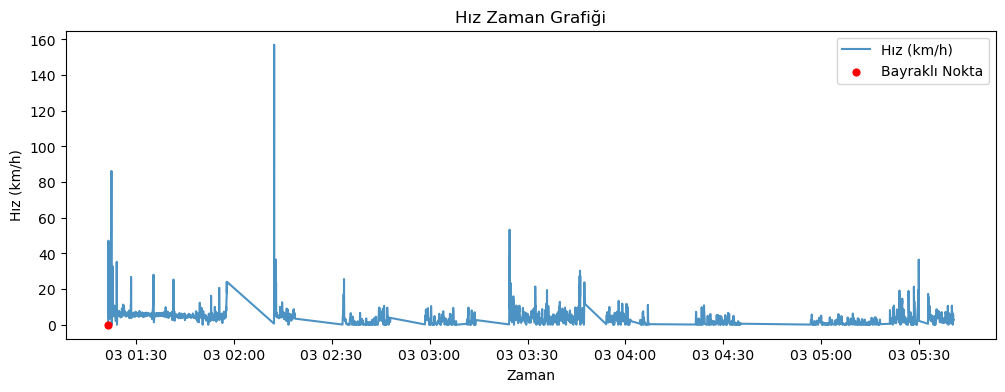

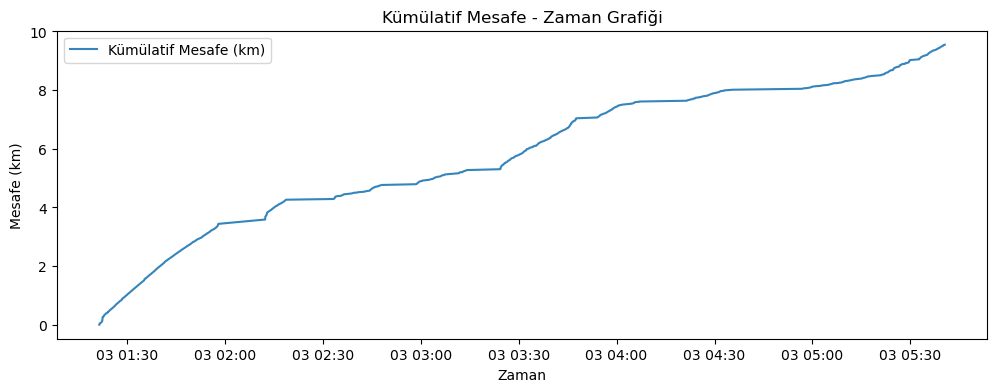

In [ ]:

# === 2d Güvenli Başlangıç: türev kolonlar yoksa yerinde üret ===

import numpy as np
import matplotlib.pyplot as plt

need_base = {"ts", "lat", "lon"}
if not need_base.issubset(df.columns):
    raise ValueError("df beklenen ham kolonları içermiyor (ts, lat, lon). 2b/2c'yi çalıştır.")

have_metrics = {"dt_s", "dist_m", "speed_mps", "speed_kmh"}.issubset(df.columns)

if not have_metrics:
    # Haversine (metre)
    def haversine_m(lat1, lon1, lat2, lon2):
        R = 6371000.0
        lat1 = np.radians(lat1)
        lon1 = np.radians(lon1)
        lat2 = np.radians(lat2)
        lon2 = np.radians(lon2)
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
        return 2 * R * np.arcsin(np.sqrt(a))

    # Zaman farkı (sn)
    df = df.sort_values("ts").copy()
    df["dt_s"] = df["ts"].diff().dt.total_seconds().fillna(0)

    # Konum farkı -> mesafe (m)
    d = haversine_m(df["lat"].shift(), df["lon"].shift(), df["lat"], df["lon"])
    # dt<=0 olan ve/veya NaN olan yerleri 0 yap
    df["dist_m"] = np.where(df["dt_s"].to_numpy() > 0, np.nan_to_num(d.to_numpy(), nan=0.0), 0.0)

    # Hız (m/s, km/h)
    eps = 1e-6
    df["speed_mps"] = df["dist_m"] / np.maximum(df["dt_s"], eps)
    df["speed_kmh"] = df["speed_mps"] * 3.6

# === Bayraklar: yoksa üret (have_metrics True olsa bile güvence) ===
if "flag_dt_le0" not in df.columns:
    df["flag_dt_le0"] = df["dt_s"] <= 0
if "flag_longjump" not in df.columns:
    df["flag_longjump"] = df["dist_m"] > 1000        # eşiğini istediğin gibi değiştir
if "flag_v_extreme" not in df.columns:
    df["flag_v_extreme"] = df["speed_kmh"] > 200     # eşiğini istediğin gibi değiştir


# Hız grafiği
plt.figure(figsize=(12, 4))
plt.plot(df["ts"], df["speed_kmh"], label="Hız (km/h)", alpha=0.8)

mask_flags = df["flag_dt_le0"] | df["flag_longjump"] | df["flag_v_extreme"]
if mask_flags.any():
    plt.scatter(
        df.loc[mask_flags, "ts"],
        df.loc[mask_flags, "speed_kmh"],
        color="red",
        s=24,
        zorder=3,
        label="Bayraklı Nokta",
    )
plt.title("Hız Zaman Grafiği")
plt.xlabel("Zaman")
plt.ylabel("Hız (km/h)")
plt.legend()
plt.show()

# Kümülatif mesafe grafiği
plt.figure(figsize=(12, 4))
cum_km = df["dist_m"].fillna(0).cumsum() / 1000.0
plt.plot(df["ts"], cum_km, label="Kümülatif Mesafe (km)", alpha=0.9)
plt.title("Kümülatif Mesafe - Zaman Grafiği")
plt.xlabel("Zaman")
plt.ylabel("Mesafe (km)")
plt.legend()
plt.show()


In [78]:
# === Hücre 3a: Geolife -> toplu işleme, özet çıkarma ve diske yazma ===
from pathlib import Path
import numpy as np
import pandas as pd
from datetime import timedelta

PROJECT_ROOT = Path("/Users/berkaybakac/Projects/geosentinel")
DATA_DIR     = PROJECT_ROOT / "data" / "raw" / "geolife" / "Data"
OUT_DIR      = PROJECT_ROOT / "data" / "interim" / "geolife_proc"
OUT_DIR.mkdir(parents=True, exist_ok=True)
(OUT_DIR / "tracks_parquet").mkdir(parents=True, exist_ok=True)

MAX_FILES = 200  # ilk tur için sınır; sonra artır
summ_rows = []

def haversine_m(lat1, lon1, lat2, lon2):
    R = 6371000.0
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

def parse_geolife_plt(path: Path) -> pd.DataFrame:
    # Başlık 6 satır; sonra csv benzeri 7 alan
    df = pd.read_csv(
        path, skiprows=6, header=None,
        names=["lat","lon","unused","alt_ft","days","date","time"]
    )
    # temel tipler + timestamp + metreye dönüştürme
    df["ts"] = pd.to_datetime(df["date"] + " " + df["time"])
    df["alt_m"] = df["alt_ft"].astype(float) * 0.3048
    cols = ["lat","lon","unused","alt_ft","days","date","time","ts","alt_m"]
    return df[cols].copy()

def ensure_metrics(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values("ts").copy()
    if "dt_s" not in df.columns or "dist_m" not in df.columns or "speed_kmh" not in df.columns:
        df["dt_s"] = df["ts"].diff().dt.total_seconds().fillna(0)
        df["dist_m"] = 0.0
        mask = df["dt_s"] > 0
        df.loc[mask, "dist_m"] = haversine_m(
            df["lat"].shift(), df["lon"].shift(), df["lat"], df["lon"]
        )[mask].fillna(0)
        df["speed_mps"] = np.where(df["dt_s"] > 0, df["dist_m"] / df["dt_s"], 0.0)
        df["speed_kmh"] = df["speed_mps"] * 3.6
    # Bayraklar
    df["flag_dt_le0"]    = df["dt_s"] <= 0
    df["flag_longjump"]  = df["dist_m"] > 1000
    df["flag_v_extreme"] = df["speed_kmh"] > 200
    return df

def summarize_track(df: pd.DataFrame, file_path: Path) -> dict:
    dur_s   = float(df["dt_s"].sum())
    dist_km = float(df["dist_m"].sum()/1000)
    mean_k  = float(df["speed_kmh"].mean())
    max_k   = float(df["speed_kmh"].max())
    n_flags = {
        "n_dt_le0": int(df["flag_dt_le0"].sum()),
        "n_jump":   int(df["flag_longjump"].sum()),
        "n_v_ext":  int(df["flag_v_extreme"].sum()),
    }
    return dict(
        file=str(file_path),
        t_start=df["ts"].min(), t_end=df["ts"].max(),
        duration_min=dur_s/60.0, distance_km=dist_km,
        mean_speed_kmh=mean_k, max_speed_kmh=max_k,
        **n_flags, n_points=int(len(df))
    )

# Dosyaları topla
plt_files = []
for udir in sorted(DATA_DIR.iterdir()):
    traj_dir = udir / "Trajectory"
    if traj_dir.is_dir():
        plt_files.extend(sorted(traj_dir.glob("*.plt")))
    if len(plt_files) >= MAX_FILES:
        break
plt_files = plt_files[:MAX_FILES]

print(f"İşlenecek dosya sayısı: {len(plt_files)}")

for p in tqdm(plt_files):
    try:
        df_raw = parse_geolife_plt(p)
        df_met = ensure_metrics(df_raw)

        # İsteğe bağlı: uç değer temizliği (çok agresif değil)
        # Örn: negatif/0 dt_s olan satırlarda hız=0 olarak kalsın; uzun zıplamaları düşürmek istersen:
        # df_met = df_met.loc[~df_met["flag_longjump"]].copy()

        # track'i parquet olarak kaydet
        out_name = (OUT_DIR / "tracks_parquet" / (p.stem + ".parquet"))
        df_met.to_parquet(out_name, index=False)

        # özet satır
        summ_rows.append(summarize_track(df_met, p))

    except Exception as e:
        # sorunlu dosyayı logla ve devam et
        summ_rows.append(dict(file=str(p), error=str(e)))

# Özet tabloyu kaydet
summ = pd.DataFrame(summ_rows)
summ_path = OUT_DIR / "summaries.parquet"
summ.to_parquet(summ_path, index=False)
print(f"\nÖzet tablo kaydedildi: {summ_path}")
print("İlk 5 özet satır:")
display(summ.head())


İşlenecek dosya sayısı: 200


100%|██████████| 200/200 [00:01<00:00, 170.94it/s]


Özet tablo kaydedildi: /Users/berkaybakac/Projects/geosentinel/data/interim/geolife_proc/summaries.parquet
İlk 5 özet satır:


,file,t_start,t_end,duration_min,distance_km,mean_speed_kmh,max_speed_kmh,n_dt_le0,n_jump,n_v_ext,n_points
0,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-10-23 02:53:04,2008-10-23 11:11:12,498.133333,14.938621,8.072699,218.098618,1,2,1,908
1,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-10-24 02:09:59,2008-10-24 02:47:06,37.116667,1.303660,3.461894,104.127482,1,0,0,244
2,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-10-26 13:44:07,2008-10-26 15:04:07,80.000000,18.648325,10.550068,131.930315,1,3,0,745
3,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-10-27 11:54:49,2008-10-27 12:05:54,11.083333,1.895661,6.959865,19.374918,1,0,0,50
4,/Users/berkaybakac/Projects/geosentinel/data/r...,2008-10-28 00:38:26,2008-10-28 05:03:42,265.266667,8.598824,3.691051,71.273991,1,0,0,1477
